#### <b>Download the Dataset</b>

* The dataset contains approximately 13,000 Korean "human face" images.
* In this dataset, all faces are cropped to a resolution of 128 X 128 pixels, although some of the original images have been high resolution.
* Each image filename indicates which family (household) number it belongs to.

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [24]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

#### <b>Family Relationship Dataset</b>

1. It consists of a total of 900 households and approximately exact 13,068 individuals.
2. The last part of the filename, such as "a1", indicates the "age group".
  * This dataset consists of 8 age group classes.
  * The task is one of the 8-classes classification problem.
  * If we perform random guessing, the accuracy is approximately 12.5%.
3. The age classification problem is somewhat challenging, thus, we expect that our dataset will be helpful for evaluating the forgetting performance of a machine unlearning algorithm.
  * Our proposed setting has been configured in a way that is almost similar to the NeurIPS Kaggle Competition 2023 held on Kaggle.
4. We have utilized "Family Relationship Dataset" from AI Hub for constructing this dataset.
  * <b>Link</b>: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=528

#### <b>Load Datasets</b>

* The following three datasets do not overlap at the household level.
  * Thus, our setting ensures any individual "subjects" are overlapped across the following three sub-dataset.
  * In other wrods, we set any person (subject) to do not simultaneously belonging to the $\mathcal{D}_{train}$, $\mathcal{D}_{test}$ and $\mathcal{D}_{unseen}$.
* <b>Training dataset $\mathcal{D}_{train}$</b>: (F0001 ~ F0299) folders have 10,025 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: (F0801 ~ F0850) folders have 1,539 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: (F0851 ~ F0900) folders have 1,504 images.

In [2]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [3]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retained.
        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

unseen_dataset = Dataset(unseen_meta_data, unseen_image_directory, unseen_transform)
unseen_dataloader = DataLoader(unseen_dataset, batch_size=64, shuffle=False)

In [5]:
forget_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=64, shuffle=True)

retain_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_train = DataLoader(retain_dataset_train, batch_size=64, shuffle=True)

forget_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False)

retain_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, retain=True)
retain_dataloader_test = DataLoader(retain_dataset_test, batch_size=64, shuffle=False)

In [6]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('Retain dataset size:', len(retain_dataset_train))
print('Unseen dataset size:', len(unseen_dataset))

Train dataset size: 10025
Test dataset size: 1539
Forget dataset size: 1500
Retain dataset size: 8525
Unseen dataset size: 1504


In [7]:
# Checking for duplicates across datasets
train_image_paths = [x[0] for x in train_dataset.image_age_list]
test_image_paths = [x[0] for x in test_dataset.image_age_list]
forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
retain_image_paths = [x[0] for x in retain_dataset_train.image_age_list]
unseen_image_paths = [x[0] for x in unseen_dataset.image_age_list]

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 1500,
 'train_retain': 8525,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

#### <b>Dataset Visualization</b>

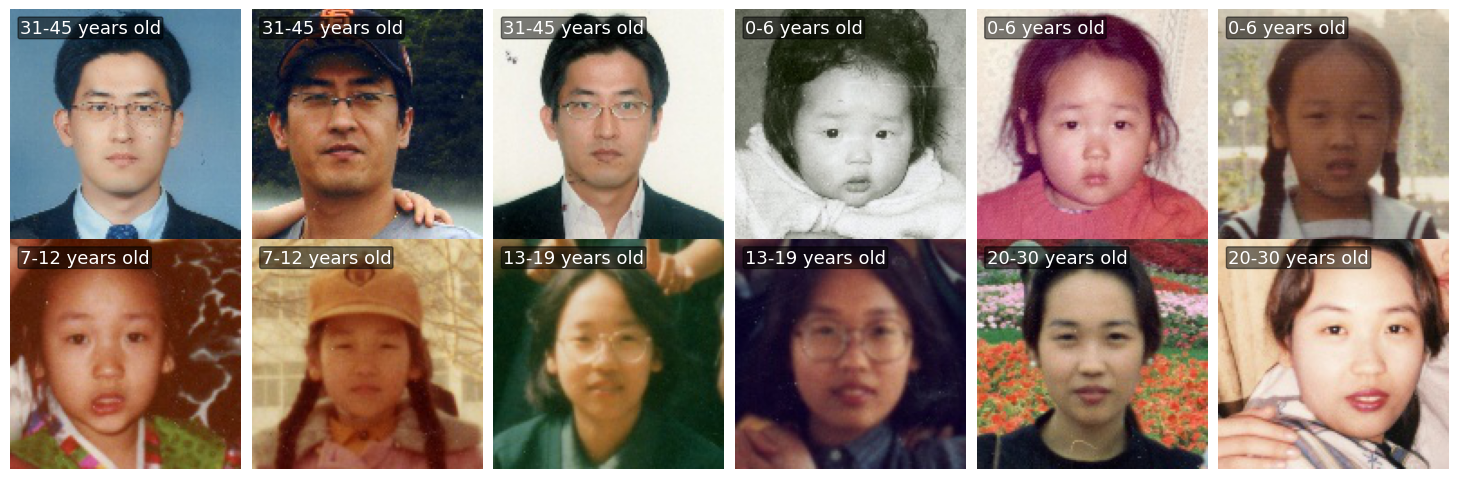

In [8]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

#### <b>Define necessary functions</b>

In [9]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed()

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

In [10]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

def calculate_jsd_between_losses(losses1, losses2):
    set_seed()
    # Generate a range of values that covers both loss arrays
    x_range = np.linspace(min(min(losses1), min(losses2)), max(max(losses1), max(losses2)), num=1000)

    # Calculate the KDE for each set of losses over the defined range
    kde1 = gaussian_kde(losses1)(x_range)
    kde2 = gaussian_kde(losses2)(x_range)

    # Normalize the KDEs to form valid probability distributions
    kde1 /= np.trapz(kde1, x_range)
    kde2 /= np.trapz(kde2, x_range)

    # Calculate JSD using the probability distributions
    jsd_value = jensenshannon(kde1, kde2)

    return jsd_value

In [17]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0
    log_step = 20

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [48]:
import seaborn as sns
def plot_kde_losses(losses1, losses2, data1="Forget", data2="Unseen", model_name="Model", figsize=(9, 5)):
    sns.set(style="whitegrid", rc={'axes.linewidth': 2, 'grid.linewidth': 0.5})

    plt.figure(figsize=figsize)

    # Plot the KDE for each set of losses
    sns.kdeplot(losses1, fill=True, color="#0B486B", label=f'{data1} Dataset Losses', alpha=0.4, linewidth=2.0)
    sns.kdeplot(losses2, fill=True, color="#D32F2F", label=f'{data2} Dataset Losses', alpha=0.4,linewidth=2.0)

    # Simplify the legend to show only one label per group
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=15)

    title = f'Loss Distribution between {data1} and {data2} Datasets in {model_name} Model'
    plt.title(title, fontsize=14)
    plt.xlabel('Loss Value', fontsize=15)
    plt.ylabel('Density', fontsize=15)

    # Save the figure
#     plt.savefig(f"{model_name}_{data1}_{data2}_Losses_Distribution.png", dpi=300, bbox_inches='tight')
#     plt.savefig(f"{model_name}_{data1}_{data2}_Losses_Distribution.pdf", dpi=300, bbox_inches='tight')

    plt.show()

#### <b>Train the "Original Model"</b>

* Train the Original model to serve as the base model for performing Machine Unlearning

In [19]:
# ResNet18
def load_model(num_classes, model_path=None):
    model =  models.resnet18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    moodel = model.cuda()
    if model_path:
        model.load_state_dict(torch.load(model_path))
    return model

In [25]:
def train(model, dataloader):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step = 30

    for i, batch in enumerate(dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test(model, dataloader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step = 30

    for i, batch in enumerate(dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [26]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [29]:
set_seed()

learning_rate = 0.01
log_step = 20
model = load_model(8, model_path=None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_original_epochs = 30
best_test_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_original_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train(model, train_dataloader)
    test_loss, test_acc = test(model, test_dataloader)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

    if test_acc > best_test_acc:
        print("[Info] best test accuracy!")
        best_test_acc = test_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'./best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'./last_checkpoint_epoch_{num_original_epochs}.pth')

In [71]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [70]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#### <b>(Option) Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>: https://drive.google.com/file/d/1RgNsAZWH37MTWsxUdieGQFSVlweC1LsM/view?usp=drive_link

In [30]:
!gdown https://drive.google.com/uc?id=1RgNsAZWH37MTWsxUdieGQFSVlweC1LsM -O pre_trained_last_checkpoint_epoch_30.pth

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pQvc30KVSj--RwB8ekznoNDsIWF8b1_v
From (redirected): https://drive.google.com/uc?id=1pQvc30KVSj--RwB8ekznoNDsIWF8b1_v&confirm=t&uuid=a379ae7a-0edd-438c-a357-8f5c77adce2d
To: /home/dasol/02_FM/ResNet_multi_label_64/lala.pth
100%|██████████████████████████████████████| 44.8M/44.8M [00:01<00:00, 41.2MB/s]


<b>Final Test</b>

In [31]:
model_path = 'pre_trained_last_checkpoint_epoch_30.pth'
model = load_model(8, model_path)
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(model, test_dataloader)
unseen_acc = evaluation(model, unseen_dataloader)
mia = cal_mia(model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
model_forget_losses = compute_losses(model, forget_dataloader_test)
model_unseen_losses = compute_losses(model, unseen_dataloader)
jsd = calculate_jsd_between_losses(model_forget_losses, model_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print()
print(f'Final Score: {final_score}')
print(f'JSD: {jsd}')

[Test]
[Batch: 1] running test loss: 0.023215658962726593, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.024261729186400773, running test accuracy: 0.60390625, running top-2 accuracy: 0.8875
test loss: 0.02659713335049625, accuracy: 0.5971410006497726, top-2 accuracy: 0.8856400259909032
elapsed time: 1.1959083080291748
[Test]
[Batch: 1] running test loss: 0.019177664071321487, running test accuracy: 0.640625, running top-2 accuracy: 0.953125
[Batch: 20] running test loss: 0.020300325565040113, running test accuracy: 0.65390625, running top-2 accuracy: 0.903125
test loss: 0.021293988094684926, accuracy: 0.6549202127659575, top-2 accuracy: 0.9002659574468085
elapsed time: 1.1514735221862793
Test Acc: {'Loss': 0.02659713335049625, 'Acc': 0.5971410006497726, 'Top-2 Acc': 0.8856400259909032}
Unseen Acc: {'Loss': 0.021293988094684926, 'Acc': 0.6549202127659575, 'Top-2 Acc': 0.9002659574468085}
MIA: {'MIA': 0.7139534883720932, 'Forgeting Score

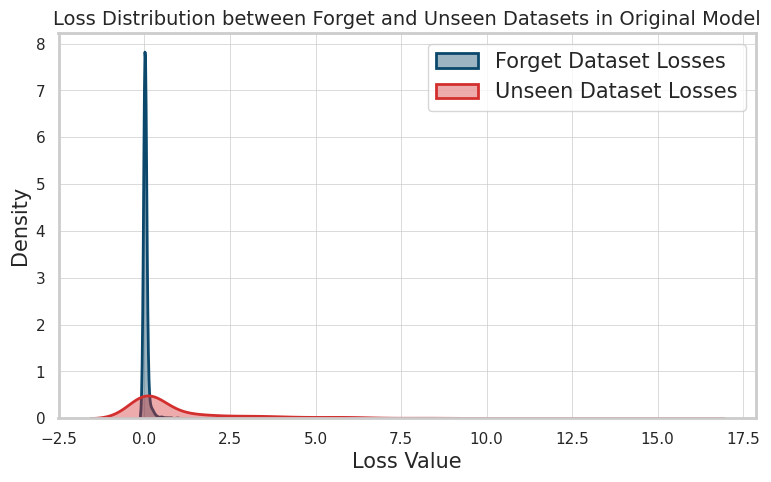

In [49]:
# visualize loss distribution
plot_kde_losses(model_forget_losses, model_unseen_losses, data1="Forget", data2="Unseen", model_name="Original")

#### <b> Train the "Retrained Model"</b>
* A model trained on only the retain dataset from scratch, excluding the forget dataset.
* This model can serve as a proxy ground-truth for calculating the potential ground-truth (1) model utility and (2) forgetting score.

In [33]:
set_seed()

num_epochs = 30
best_test_acc = 0
best_epoch = 0
learning_rate = 0.01
retrained_model = load_model(8, None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retrained_model.parameters(), lr=learning_rate, momentum=0.9)

history = []
accuracy = []
for epoch in range(num_epochs):

    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train(retrained_model, retain_dataloader_train)
    test_loss, test_acc = test(retrained_model, test_dataloader)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

    if test_acc > best_test_acc:
        print("[Info] best test accuracy!")
        best_test_acc = test_acc
        best_epoch = epoch

[Epoch: 1 - Training]
[Batch: 30] running train loss: 0.032296557414035004, running train accuracy: 0.19322918355464935
[Batch: 60] running train loss: 0.03167468920970957, running train accuracy: 0.22031250596046448
[Batch: 90] running train loss: 0.0310691279048721, running train accuracy: 0.24027778208255768
[Batch: 120] running train loss: 0.030604760488495232, running train accuracy: 0.25468751788139343
train loss: 0.03045185964478076, accuracy: 0.259472131729126
elapsed time: 19.045799016952515
[Test]
[Batch: 1] running test loss: 0.03162093088030815, running test accuracy: 0.234375
test loss: 0.03134974920571509, accuracy: 0.29369720816612244
elapsed time: 1.2372570037841797
[Info] best test accuracy!
[Epoch: 2 - Training]
[Batch: 30] running train loss: 0.027288167426983517, running train accuracy: 0.3395833373069763
[Batch: 60] running train loss: 0.026851760875433683, running train accuracy: 0.3476562798023224
[Batch: 90] running train loss: 0.026169442820052305, running trai

train loss: 0.010449656681580977, accuracy: 0.7496774196624756
elapsed time: 18.631326913833618
[Test]
[Batch: 1] running test loss: 0.018374985083937645, running test accuracy: 0.484375
test loss: 0.02080616968804323, accuracy: 0.5074723958969116
elapsed time: 1.313755989074707
[Epoch: 13 - Training]
[Batch: 30] running train loss: 0.00914171920157969, running train accuracy: 0.7828125357627869
[Batch: 90] running train loss: 0.007472895836043689, running train accuracy: 0.8277778029441833
[Batch: 120] running train loss: 0.0075876684083292885, running train accuracy: 0.8252604603767395
train loss: 0.007716572148359416, accuracy: 0.8233430981636047
elapsed time: 18.59087300300598
[Test]
[Batch: 1] running test loss: 0.02144628018140793, running test accuracy: 0.578125
test loss: 0.024312915702854525, accuracy: 0.4775828421115875
elapsed time: 1.2394933700561523
[Epoch: 19 - Training]
[Batch: 30] running train loss: 0.007451261300593615, running train accuracy: 0.8229166865348816
[Batc

train loss: 0.006009210685481074, accuracy: 0.8699120283126831
elapsed time: 19.39069676399231
[Test]
[Batch: 1] running test loss: 0.02122771367430687, running test accuracy: 0.546875
test loss: 0.02435779385631777, accuracy: 0.4938271641731262
elapsed time: 1.2196564674377441
[Epoch: 30 - Training]
[Batch: 30] running train loss: 0.005971376163264115, running train accuracy: 0.8687500357627869
[Batch: 60] running train loss: 0.005955576112804313, running train accuracy: 0.8679687976837158
[Batch: 90] running train loss: 0.006018837391295367, running train accuracy: 0.8678819537162781
[Batch: 120] running train loss: 0.006097937709031006, running train accuracy: 0.8657552599906921
train loss: 0.006109569817344464, accuracy: 0.8655718564987183
elapsed time: 18.6073579788208
[Test]
[Batch: 1] running test loss: 0.021783234551548958, running test accuracy: 0.546875
test loss: 0.024644599323384246, accuracy: 0.4795321822166443
elapsed time: 1.3077309131622314


In [37]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [36]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [38]:
# Performance
test_acc = evaluation(retrained_model, test_dataloader)
unseen_acc = evaluation(retrained_model, unseen_dataloader)
mia = cal_mia(retrained_model.cuda())
final_score = (test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2
retrained_forget_losses = compute_losses(retrained_model, forget_dataloader_test)
retrained_unseen_losses = compute_losses(retrained_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(retrained_forget_losses, retrained_unseen_losses)

print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print()
print(f'Final Score: {final_score}')
print(f'JSD: {jsd}')

[Test]
[Batch: 1] running test loss: 0.021783234551548958, running test accuracy: 0.546875, running top-2 accuracy: 0.8125
[Batch: 20] running test loss: 0.023612363450229167, running test accuracy: 0.4703125, running top-2 accuracy: 0.7640625
test loss: 0.024644599323384246, accuracy: 0.47953216374269003, top-2 accuracy: 0.7634827810266407
elapsed time: 1.3441052436828613
[Test]
[Batch: 1] running test loss: 0.02050713635981083, running test accuracy: 0.515625, running top-2 accuracy: 0.828125
[Batch: 20] running test loss: 0.02001723307184875, running test accuracy: 0.58046875, running top-2 accuracy: 0.81328125
test loss: 0.02057639053685868, accuracy: 0.5844414893617021, top-2 accuracy: 0.8125
elapsed time: 1.2415485382080078
Test Acc: {'Loss': 0.024644599323384246, 'Acc': 0.47953216374269003, 'Top-2 Acc': 0.7634827810266407}
Unseen Acc: {'Loss': 0.02057639053685868, 'Acc': 0.5844414893617021, 'Top-2 Acc': 0.8125}
MIA: {'MIA': 0.5382059800664452, 'Forgeting Score': 0.03820598006644

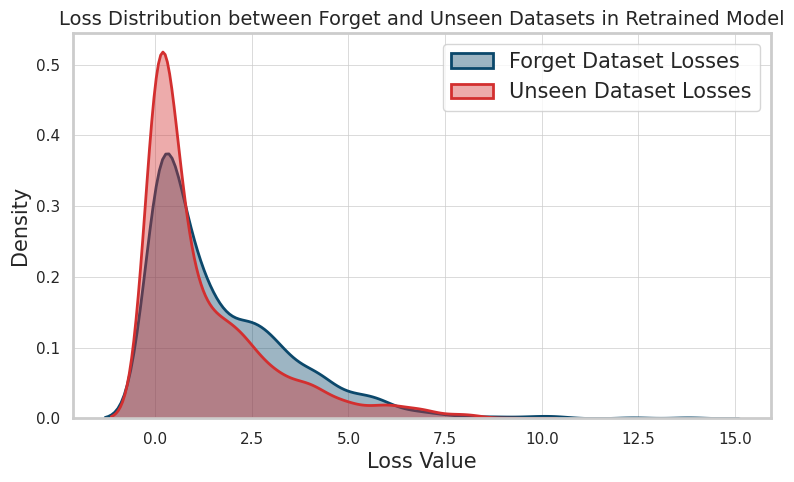

In [50]:
# visualize loss distribution
plot_kde_losses(retrained_forget_losses, retrained_unseen_losses, data1="Forget", data2="Unseen", model_name="Retrained")